In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("..")

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
from scipy import sparse
import pandas as pd

import paper.eval as eval
from paper.DPAH_multiple_minorities import DPAH

## model parameters

In [8]:
# Number of nodes
N = 2000

# max edge density
d = 0.002

# Top beta% of rankings to consider for inequity
beta = 0.1

# Top k nodes to consider for inequity. k = N * beta
k = int(N * beta)

# Minority fractions
fm1 = 0.1
fm2 = 0.1

# Activity distribution parameters
plo_M = 3
plo_m1 = 3
plo_m2 = 3

# homophily
#h_MM = 1/3
#h_Mm = (1.0 - h_MM)/2.0
#h_within = 0.7
#h_between = 0.1
#h_mM = (1.0 - h_within - h_between)
#
#h = [[h_MM, h_Mm, h_Mm],
#    [h_mM, h_within, h_between],
#    [h_mM, h_between, h_within]]

In [9]:
def compute_inequity(g, k):
    """Compute the proportion of minorities in the top k ranks of g"""
    node_pageranks = nx.pagerank(g)
    node_pageranks_sorted = sorted(node_pageranks.items(), key=lambda x: x[1], reverse=True)
    top_k = node_pageranks_sorted[:k]
    num_top_k_minority = np.count_nonzero([g.nodes[node_id]['m'] for (node_id, _) in top_k])
    
    return num_top_k_minority / k  

## experiment parameters

In [14]:
runs = 10

In [15]:
h_MM_options = [0.2,1/3,0.8]
h_mm_options = [0.1,0.5,0.9]

# EXPERIMENTS

In [16]:
t = 0
for i in h_MM_options:
    for j in h_mm_options:
        t += 1
        print('Experiment', t)
        # homophily
        h_MM = i
        h_Mm = (1.0 - h_MM)/2.0
        h_within = j
        h_between = 0
        h_mM = (1.0 - h_within - h_between)

        h = [[h_MM, h_Mm, h_Mm],
            [h_mM, h_within, h_between],
            [h_mM, h_between, h_within]]
        print(h_MM)
        print(h_within)

Experiment 1
0.2
0.1
Experiment 2
0.2
0.5
Experiment 3
0.2
0.9
Experiment 4
0.3333333333333333
0.1
Experiment 5
0.3333333333333333
0.5
Experiment 6
0.3333333333333333
0.9
Experiment 7
0.8
0.1
Experiment 8
0.8
0.5
Experiment 9
0.8
0.9


In [35]:
simulation 1 = experiment 6
simulation 2 = experiment 3
simulation 3 = experiment 9
simulation 4 = experiment 5
simulation 5 = experiment 2
simulation 6 = experiment 8
simulation 7 = experiment 4
simulation 8 = experiment 1
simulation 9 = experiment 7



SyntaxError: invalid syntax (2806412784.py, line 1)

In [17]:
t = 0

inequities = {}

for i in h_MM_options:
    for j in h_mm_options:
        t += 1
        print('Experiment', t)

        # homophily
        h_MM = i
        h_Mm = max(0,(1.0 - h_MM)/2.0)
        h_within = j
        h_between = 0
        h_mM = max(0,(1.0 - h_within - h_between))

        h = [[h_MM, h_Mm, h_Mm],
            [h_mM, h_within, h_between],
            [h_mM, h_between, h_within]]

        #graphs = []
        start_time = time.time()
        results =[]


        for r in range(runs):
            g = DPAH(N=N, d=d, fm1=fm1, fm2=fm2, plo_M=plo_M, plo_m1=plo_m1, plo_m2=plo_m2, h=h, verbose=False, seed=r)
            node_identities = [[node_id,g.nodes[node_id]['m']] for node_id in list(g.nodes())]
            ineq= compute_inequity(g, 50)
            inequities[f'{str(t)}_{str(r)}']=ineq
            df = pd.DataFrame(node_identities,columns=['node_id','group'])
            df.to_csv(f"networks/nodelist_{str(t)}_run_{str(r)}.csv",index=False)
            adj = nx.to_scipy_sparse_array(g,nodelist = list(g.nodes()))
            adj = sparse.coo_matrix(adj)
            sparse.save_npz(f"networks/adj_matrix_type_{str(t)}_run_{str(r)}.npz", adj)

        end_time = time.time()
        print("finished {} run(s) with {} nodes each in {} seconds".format(runs, N, str(round((end_time - start_time), 2))))

Experiment 1
finished 10 run(s) with 2000 nodes each in 843.98 seconds
Experiment 2
finished 10 run(s) with 2000 nodes each in 839.01 seconds
Experiment 3
finished 10 run(s) with 2000 nodes each in 870.59 seconds
Experiment 4
finished 10 run(s) with 2000 nodes each in 845.25 seconds
Experiment 5
finished 10 run(s) with 2000 nodes each in 841.53 seconds
Experiment 6
finished 10 run(s) with 2000 nodes each in 848.1 seconds
Experiment 7
finished 10 run(s) with 2000 nodes each in 847.59 seconds
Experiment 8
finished 10 run(s) with 2000 nodes each in 846.31 seconds
Experiment 9
finished 10 run(s) with 2000 nodes each in 848.15 seconds


In [21]:
results = {}
deviations={}
for t in range(9):
    t = t +1
    experiment= []
    for r in range(10):
        experiment = np.append(experiment,inequities[f'{str(t)}_{str(r)}'])
    results[f'{str(t)}'] = np.mean(experiment)
    deviations[f'{str(t)}'] = np.std(experiment)
    

In [39]:
results.keys()

right_order = ['6','3','9','5','2','8','4','1','7']

yval = []
std = []
for o in right_order:
    yval = np.append(yval,results[o])
    std = np.append(std,deviations[o])

In [25]:
results.values()

dict_values([0.384, 0.45000000000000007, 0.76, 0.10800000000000001, 0.148, 0.5079999999999999, 0.004, 0.006, 0.004])

In [41]:
plt.plot(results.keys(),yval,'o-')
plt.fill_between(results.keys(),[a-b for a,b in zip(yval,std)],
                [a+b for a,b in zip(yval,std)],alpha=0.2)
plt.title('Percentage of minorities in top 50 rank')
plt.ylabel('% top 50')
plt.xlabel('Experiment nº')
plt.plot(results.keys(),(fm1+fm2)*np.ones(9),'r',label = 'Real proportion')

plt.legend()

plt.savefig('top50_experiments.png')

In [18]:
#TO READ
t = 1
r =2

#EDGE_LIST
adj = sparse.load_npz(f"networks/adj_matrix_type_{str(t)}_run_{str(r)}.npz")
edge_list = np.column_stack((adj.row,adj.col,adj.data))
el_dataframe = pd.DataFrame(edge_list,columns = ['source','target','is_link'])


#NODE_LIST
df_nodes = pd.read_csv(f"networks/nodelist_{str(t)}_run_{str(r)}.csv",index_col= 'node_id')


FileNotFoundError: [Errno 2] No such file or directory: 'networks/adj_matrix_type_9_run_0.8.npz'

In [ ]:
el_dataframe.head()

In [ ]:
df_nodes.head()

### Experiment 4

In [ ]:
fig =  plt.subplots(1, figsize=(5,3))
plt.plot(size_values, prop_top, label ='proportion of minority in top 20')
plt.fill_between(size_values,[a-b for a,b in zip(prop_top,prop_top_std)],[a+b for a,b in zip(prop_top,prop_top_std)],alpha=0.4)


plt.plot(size_values,size_values*2,'r',label = 'Real proportion')
#plt.xlim(-1,28)
plt.ylim(0,1)
plt.xlabel('Minority size',fontsize=13)
plt.ylabel('Proportion of minority',fontsize=13)

plt.title('Experiment whatever',fontsize=14)
plt.legend()
plt.tight_layout()
#plt.savefig('../../figures/timeline_temporary_track_max.png',dpi=200)

### Experiment3

In [ ]:
fig =  plt.subplots(1, figsize=(5,3))
plt.plot(h_MM_values, prop_top, label ='proportion of minority in top 20')
plt.fill_between(h_MM_values,[a-b for a,b in zip(prop_top,prop_top_std)],[a+b for a,b in zip(prop_top,prop_top_std)],alpha=0.4)


plt.plot(h_MM_values,(fm1+fm2)*np.ones(10),'r',label = 'Real proportion')
#plt.xlim(-1,28)
plt.ylim(0,1)
plt.xlabel('h_MM (decrease of hMm)',fontsize=13)
plt.ylabel('Proportion of minority',fontsize=13)

plt.title('Experiment whatever',fontsize=14)
plt.legend()
plt.tight_layout()
#plt.savefig('../../figures/timeline_temporary_track_max.png',dpi=200)

### Experiment2

NameError: name 'h_between_values' is not defined

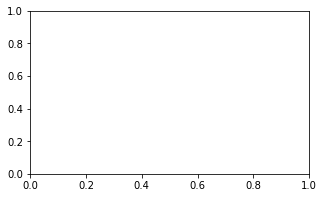

In [14]:
fig =  plt.subplots(1, figsize=(5,3))
plt.plot(h_between_values, prop_top, label ='proportion of minority in top 20')
plt.fill_between(h_between_values,[a-b for a,b in zip(prop_top,prop_top_std)],[a+b for a,b in zip(prop_top,prop_top_std)],alpha=0.4)


plt.plot(h_between_values,(fm1+fm2)*np.ones(10),'r',label = 'Real proportion')
#plt.xlim(-1,28)
plt.ylim(0.15,0.4)
plt.xlabel('h_between (decrease of hmM)',fontsize=13)
plt.ylabel('Proportion of minority',fontsize=13)

plt.title('Experiment whatever',fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('between.png',dpi=200)

### Experiment1

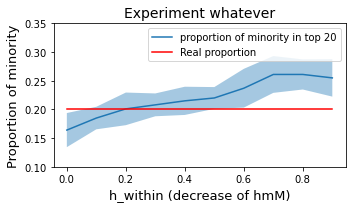

In [99]:
fig =  plt.subplots(1, figsize=(5,3))
plt.plot(h_within_values, prop_top, label ='proportion of minority in top 20')
plt.fill_between(h_within_values,[a-b for a,b in zip(prop_top,prop_top_std)],[a+b for a,b in zip(prop_top,prop_top_std)],alpha=0.4)


plt.plot(h_within_values,(fm1+fm2)*np.ones(10),'r',label = 'Real proportion')
#plt.xlim(-1,28)
plt.ylim(0.1,0.35)
plt.xlabel('h_within (decrease of hmM)',fontsize=13)
plt.ylabel('Proportion of minority',fontsize=13)

plt.title('Experiment whatever',fontsize=14)
plt.legend()
plt.tight_layout()
#plt.savefig('../../figures/timeline_temporary_track_max.png',dpi=200)

## analysis

In [7]:
def draw_graph(g):
    maj_nodelist = []
    min1_nodelist = []
    min2_nodelist = []

    for i in range(len(g.nodes)):
        group = g.nodes[i]['m']
        if group == 0:
            maj_nodelist.append(i)
        elif group == 1:
            min1_nodelist.append(i)
        elif group == 2:
            min2_nodelist.append(i)
        else:
            print("ERROR: group", group)

    subax2 = plt.subplot()
    pos = nx.circular_layout(g)
    nx.draw_networkx(g, nodelist=maj_nodelist, pos=pos, with_labels=False, node_size= 50, node_color='#B6312C')
    nx.draw_networkx(g, nodelist=min1_nodelist, pos=pos, with_labels=False, node_size= 50, node_color='#84CAE7')
    nx.draw_networkx(g, nodelist=min2_nodelist, pos=pos, with_labels=False, node_size= 50, node_color='#136F63')

    plt.show()

In [164]:
#investigate graph... check to see what nx can do
for g in graphs:
 #   print(g)
    draw_graph(g)
    print("average clustering coefficient:", round(nx.algorithms.average_clustering(g),3))

NameError: name 'graphs' is not defined

In [165]:
draw_graph(g)

NameError: name 'draw_graph' is not defined